## Постановка задачи

Реализовать пайплайн:

1.      Найдите в открытых источниках исторические данные о покупках смартфонов, на kaggle например. Спрофилируйте пользователей,

2.      Найдите в открытых источниках список товаров. Как вариант - спарсите наш сайт. Кластеризуйте товары,

3.      Реализовать прогнозную модель – какой пользователь, когда и какой товар (не только смартфон видимо) хотел бы приобрести,

4.      Предложите маркетинговый инструмент – куда на вход подались бы данные прогноза, а на выход получилась бы таргетированная реклама гугл. Например https://financesonline.com/top-10-free-marketing-automation-software/. 

В качестве датасета взяты данные с соревнования Instacart Market Basket Analysis: https://www.kaggle.com/c/instacart-market-basket-analysis/data 

Набор данных для этого конкурса представляет собой реляционный набор файлов, описывающих заказы клиентов во времени. Цель конкурса - предсказать, какие продукты будут заказаны. Набор данных является анонимным и содержит выборку из более чем 3 миллионов продуктовых заказов от более чем 200 000 пользователей Instacart. Для каждого пользователя мы предоставляем от 4 до 100 их заказов с последовательностью продуктов, приобретенных в каждом заказе. Мы также предоставляем неделю и час дня, когда был размещен заказ, и относительную меру времени между заказами.

Более подробное описание данных по ссылке.

## Exploratory Data Analysis (EDA)

Этот файл - разведочный анализ данных, что бы мы могли понять данные и что мы можем делать с ними дальше.

In [1]:
import pandas as pd 
import numpy as np 
import nltk 

import matplotlib.pyplot as plt 
import seaborn as sns 

from functools import partial 

color = sns.color_palette() 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Загрузка данных

In [2]:
aisles = pd.read_csv('data/aisles.csv', engine='c')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
departments = pd.read_csv('data/departments.csv', engine='c')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
products = pd.read_csv('data/products.csv', engine='c')
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
orderProductsTrain = pd.read_csv('data/order_products__train.csv')
orderProductsTrain.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
orders = pd.read_csv('data/orders.csv')
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
orderProductsPrior = pd.read_csv('data/order_products__prior.csv')
orderProductsPrior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


## Обзор данных

[Text(0.5,0,'Часы'), Text(0.5,1,'Распределение заказов по времени')]

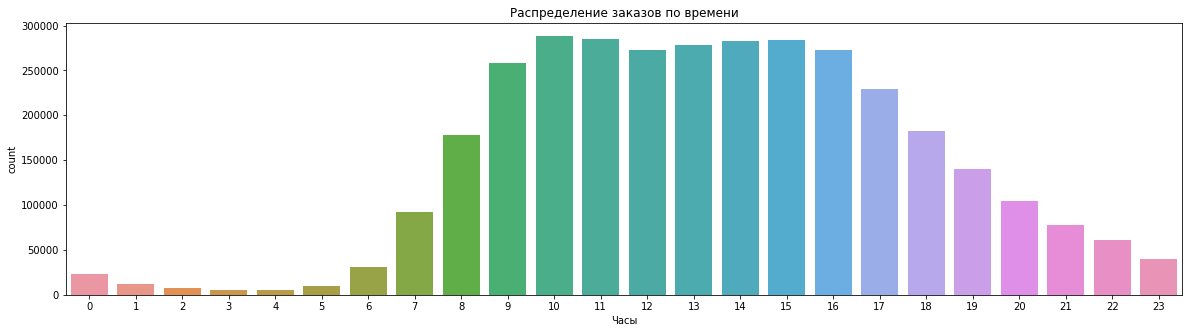

In [8]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(data=orders,x="order_hour_of_day",ax=ax)
ax.set(xlabel='Часы',title="Распределение заказов по времени")

Видим, что основная масса заказов с 9 утра и до 17 часов вечера.

[Text(0.5,0,'День недели'), Text(0.5,1,'Распределение заказов по дням недели')]

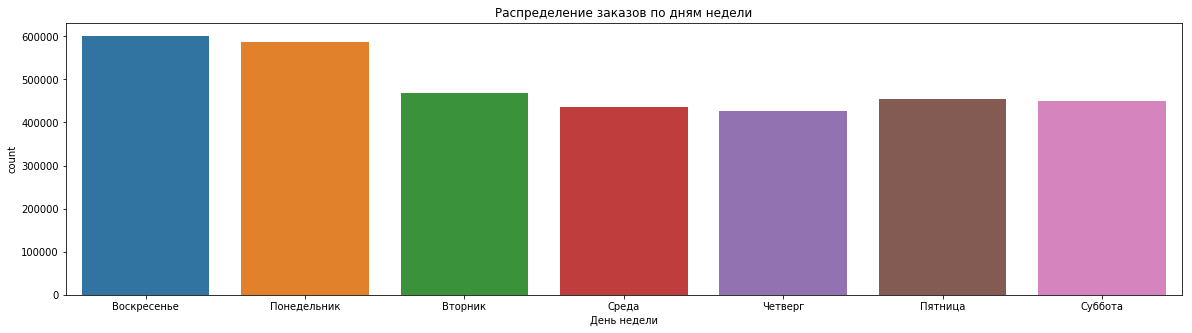

In [9]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
ordersDay = orders[["order_dow"]].replace({0:"Воскресенье",1:"Понедельник",2:"Вторник",3:"Среда",4:"Четверг",5:"Пятница",6:"Суббота"})

sns.countplot(data=ordersDay,x="order_dow",ax=ax,order=["Воскресенье","Понедельник","Вторник","Среда","Четверг","Пятница","Суббота"])
ax.set(xlabel='День недели',title="Распределение заказов по дням недели")

Основная масса заказов приходится на воскресенье и понедельник. К середине недели активность клиентов падает. 

[Text(0.5,0,'Количество заказов'),
 Text(0.5,1,'Количество заказов пользователей')]

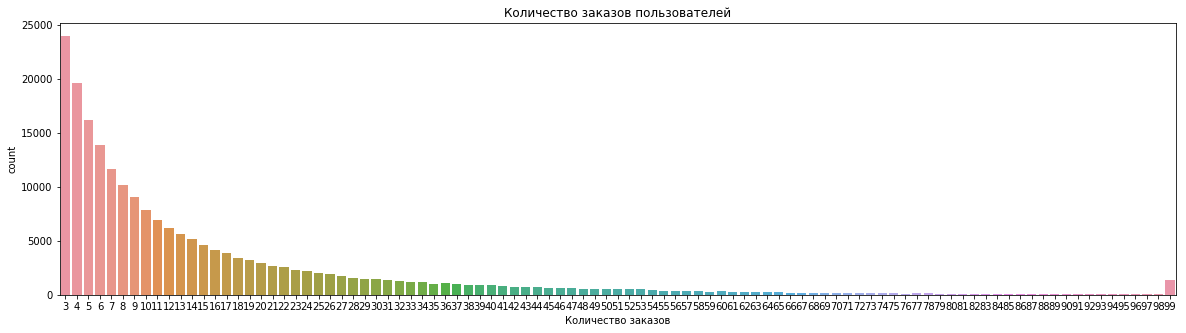

In [10]:
orderCount = orders[orders["eval_set"]=="prior"].groupby(by=["user_id"])["order_id"].count().to_frame()
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(data=orderCount,x="order_id",ax=ax)
ax.set(xlabel='Количество заказов',title="Количество заказов пользователей")

Итак большинство пользователей делают 3-6 покупок, но и есть аномалии: 99 покупок.

,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4
5,47766,7409,Organic Avocado,24,4
6,47209,7293,Organic Hass Avocado,24,4
7,16797,6494,Strawberries,24,4
8,26209,6033,Limes,24,4
9,27966,5546,Organic Raspberries,123,4


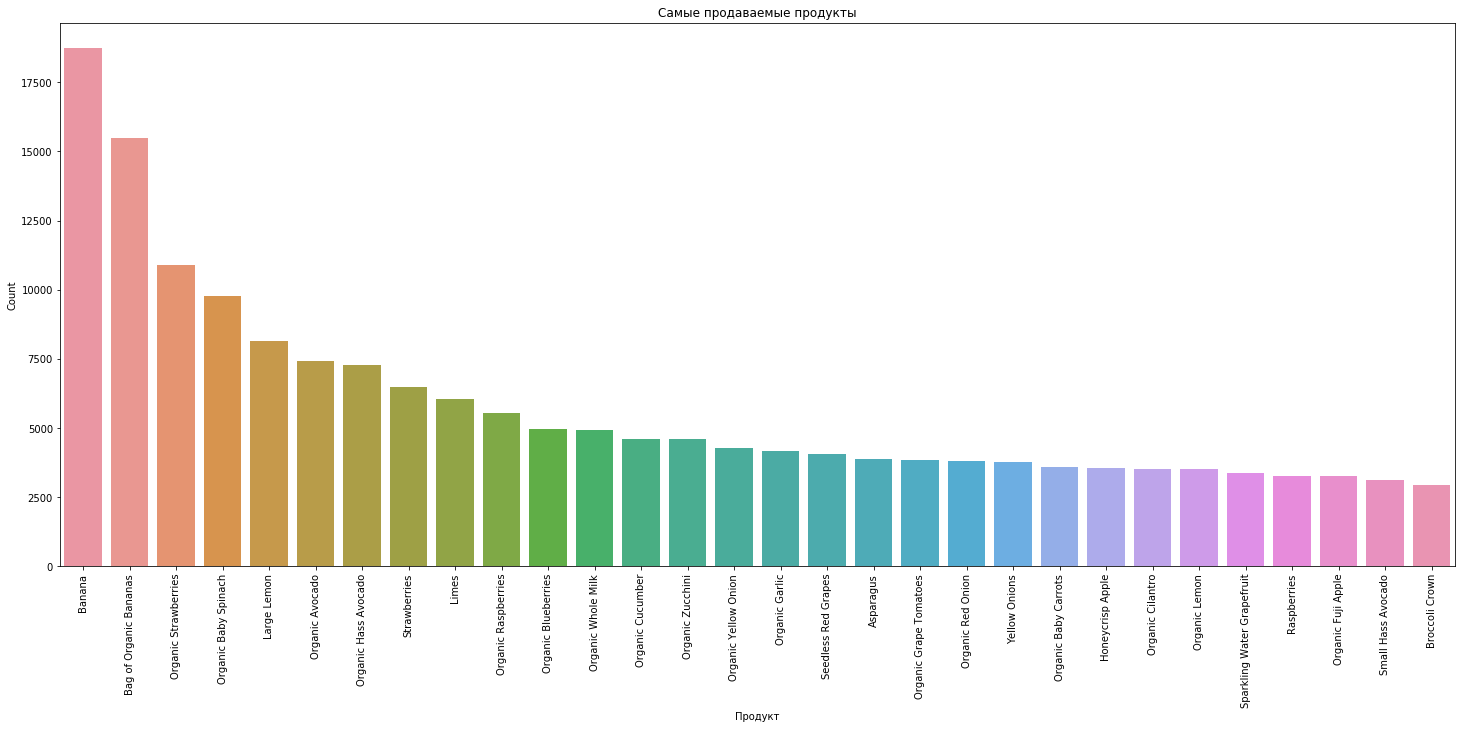

In [11]:
productsCount = orderProductsTrain["product_id"].value_counts().to_frame()
productsCount["count"] = productsCount.product_id
productsCount["product_id"] = productsCount.index
mergedData = pd.merge(productsCount,products,how="left",on="product_id").sort_values(by="count",ascending=False)

fig,ax = plt.subplots()
fig.set_size_inches(25,10)
sns.barplot(data=mergedData.head(30),x="product_name",y="count",ax=ax,orient="v")
ax.set(xlabel='Продукт',ylabel="Count",title="Самые продаваемые продукты")
plt.xticks(rotation=90)

mergedData.head(10)

Самые продаваемые продукты: бананы, земляника и шпинат.

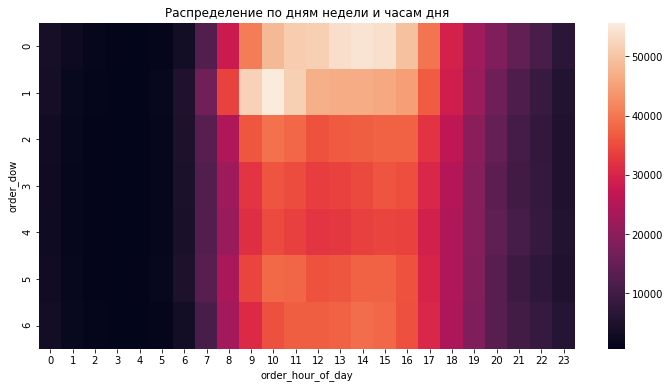

In [16]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Распределение по дням недели и часам дня")
plt.show()

Интересно выглядит распределение по дням недели и часам дня.  Кажется, субботние вечера и воскресные утра - лучшее время для заказов.

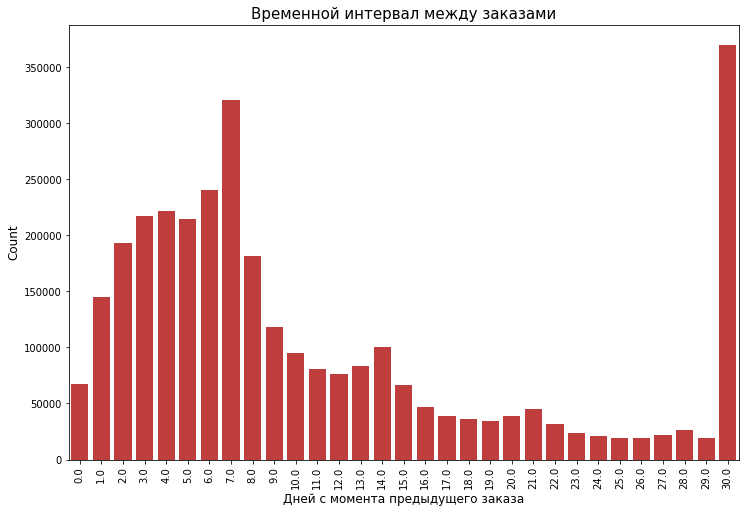

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Дней с момента предыдущего заказа', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Временной интервал между заказами", fontsize=15)
plt.show()

Временной интервал между заказами - похоже, что клиенты заказывают один раз в неделю (проверьте пик на 7 дней) или один раз в месяц (пик на 30 дней). Мы также могли видеть меньшие пики в 14, 21 и 28 дней (недельные интервалы).

Давайте проверим процент повторных заказов

In [21]:
orderProductsPrior.reordered.sum() / orderProductsPrior.shape[0]

0.5896974667922161

In [22]:
orderProductsTrain.reordered.sum() / orderProductsTrain.shape[0]

0.5985944127509629

В среднем, около 59% товаров в заказе - это товары, заказанные повторно.

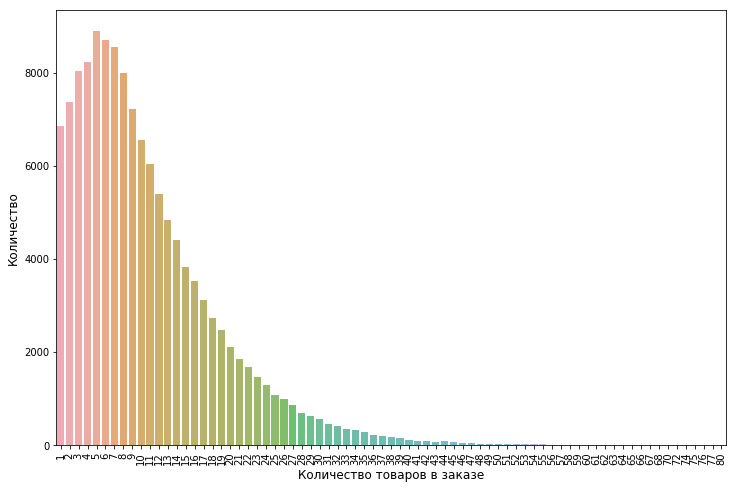

In [24]:
grouped_df = orderProductsTrain.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Количество товаров в заказе', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

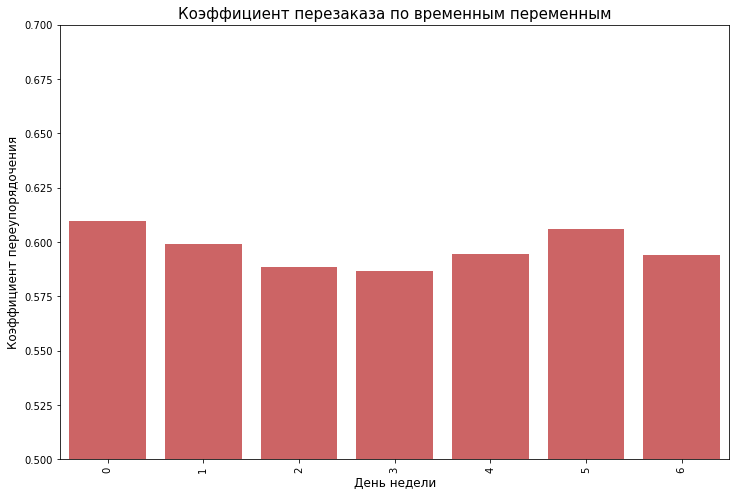

In [32]:
orderProductsTrain = pd.merge(orderProductsTrain, orders, on='order_id', how='left')
grouped_df = orderProductsTrain.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Коэффициент переупорядочения', fontsize=12)
plt.xlabel('День недели', fontsize=12)
plt.title("Коэффициент перезаказа по временным переменным", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

Похоже, что товары, добавленные в корзину изначально, с большей вероятностью будут перезаказаны по сравнению с добавленными позже. Это также имеет смысл, так как мы склонны сначала заказывать те продукты, которые мы часто покупали, а затем просматривать новые доступные продукты.

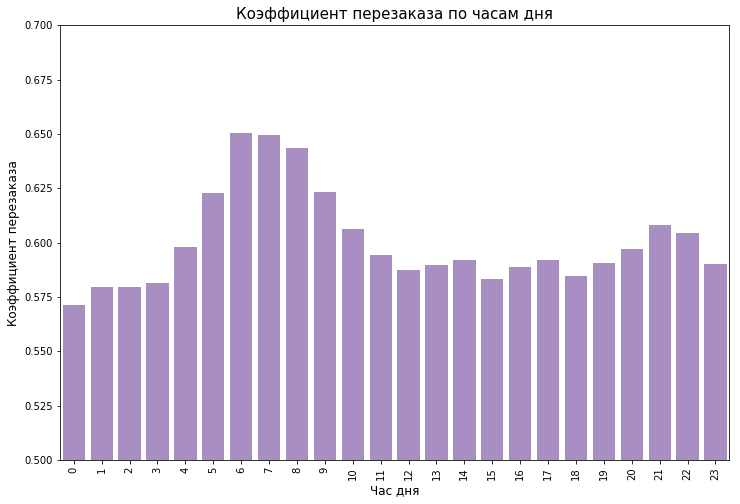

In [34]:
grouped_df = orderProductsTrain.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Коэффициент перезаказа', fontsize=12)
plt.xlabel('Час дня', fontsize=12)
plt.title("Коэффициент перезаказа по часам дня", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

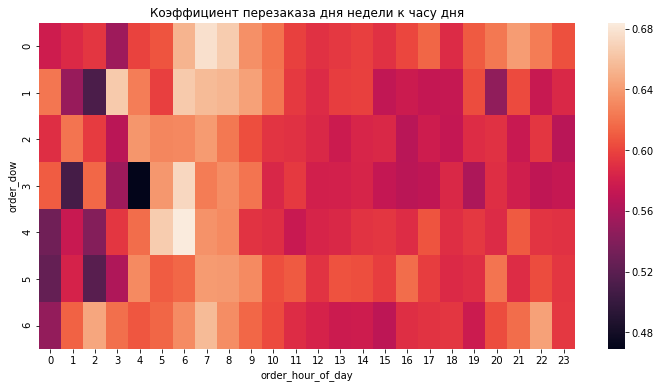

In [35]:
grouped_df = orderProductsTrain.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Коэффициент перезаказа дня недели к часу дня")
plt.show()

Коэффициенты повторного заказа довольно высоки в начале утра по сравнению с более поздней половиной дня.

Мы проверили данные. Посмотрели на клиентов, заказы. Поняли поведение клиентов. Теперь с этими знаниями мы можем перейти к сегментации клиентов